<a href="https://colab.research.google.com/github/AnastasiaBrinati/esercizi-PMCSN-23-24/blob/main/esercizio_feedback_simulazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install simpy

In [2]:
import simpy
import random
from typing_extensions import NamedTuple
import datetime

In [87]:
SIM_TIME = 1000  # Simulate until

TIMES = {
    'arrival_times' : [],
    'waiting_times' : [],
    'service_times' : []
}

In [88]:
class System(NamedTuple):
    server: simpy.Resource

In [89]:
RANDOM_SEED_ARRIVI = 123456
RANDOM_SEED_FEEDBACK = 234567
RANDOM_SEED_SERVIZI = 345678

stream_arrivi = random.Random(RANDOM_SEED_ARRIVI)
stream_feedback = random.Random(RANDOM_SEED_FEEDBACK)
stream_servizi = random.Random(RANDOM_SEED_SERVIZI)

In [90]:
def feedback():
  # eventual feedback
  beta = 0.2
  r = stream_feedback.random()
  if(r <= beta):
    # job gets feed back into the system
    return 1
  # job leaves the system
  return 0

In [91]:
def job(env, id, sys):

  flag = True
  while(flag):

    arrival_at_queue = env.now
    print("job " + id + ' arrived at %f' % arrival_at_queue)

    # Enter the queue, candidate ads a request for the server
    with sys.server.request() as my_turn:
      # Wait until it's our turn
      yield my_turn
      waiting_time = env.now - arrival_at_queue
      print('job ' + id +' waited for %f' % waiting_time)

      # Start the service
      print('job '+id+' starts being served at %f' % env.now)
      service_time = stream_servizi.uniform(1,2)
      yield env.timeout(service_time)
      # The service process has finished: Resource released automatically
      print('job '+id+' finished service at %f' % env.now)

      TIMES['service_times'].append(service_time)
      TIMES['waiting_times'].append(waiting_time)


    if(not feedback()):
      print("job " + id + " leaving the system at %f " % env.now)
      flag = False

In [92]:
arrival_rate = 0.5

def job_arrivals(env, system):
    id = 0
    """Create new *jobs* until sim time."""
    while True:
        # timeout interarrival times, waiting before generating another job
        yield env.timeout(stream_arrivi.expovariate(arrival_rate))

        # simplifying the example with fixed job size (fixed service times)
        env.process(job(env, str(id), system))
        id += 1

In [93]:
# Setup and start the simulation
print('Prova Simulazione')
env = simpy.Environment()

# Create system
system = System(
    server = simpy.Resource(env, capacity=1)
)

# Start process and run until sim time
env.process(job_arrivals(env, system))
env.run(until=SIM_TIME)

Prova Simulazione
job 0 arrived at 3.275954
job 0 waited for 0.000000
job 0 starts being served at 3.275954
job 0 finished service at 4.465447
job 0 leaving the system at 4.465447 
job 1 arrived at 6.436285
job 1 waited for 0.000000
job 1 starts being served at 6.436285
job 2 arrived at 6.496020
job 3 arrived at 6.879931
job 4 arrived at 6.884396
job 1 finished service at 7.703472
job 1 leaving the system at 7.703472 
job 2 waited for 1.207452
job 2 starts being served at 7.703472
job 2 finished service at 8.911618
job 2 leaving the system at 8.911618 
job 3 waited for 2.031687
job 3 starts being served at 8.911618
job 5 arrived at 9.064988
job 6 arrived at 9.225347
job 7 arrived at 9.850727
job 8 arrived at 10.098218
job 9 arrived at 10.618417
job 3 finished service at 10.811600
job 3 leaving the system at 10.811600 
job 4 waited for 3.927204
job 4 starts being served at 10.811600
job 10 arrived at 11.955004
job 11 arrived at 12.366852
job 12 arrived at 12.415994
job 4 finished servic

tempo medio in coda: 11.619059 


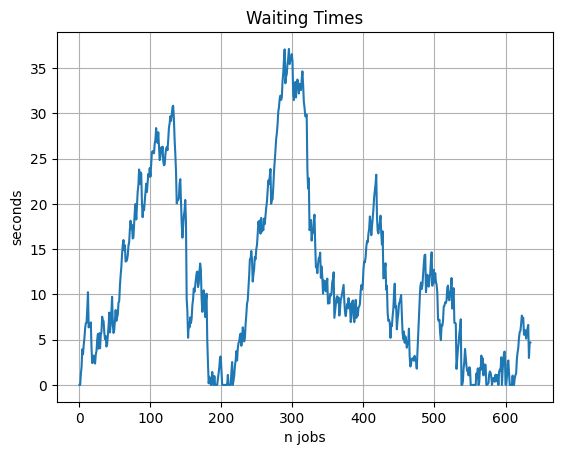

In [94]:
# Analysis/results
import numpy as np
queuing_time_avg = sum(TIMES['waiting_times']) / len(TIMES['waiting_times'])
print("tempo medio in coda: %f " % queuing_time_avg)

from matplotlib import pyplot as plt
plt.plot(TIMES['waiting_times'])

plt.ylabel('seconds')
plt.xlabel("n jobs")
plt.title("Waiting Times")
plt.grid()
plt.show()